In [3]:

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import tensorflow as tf
import time
import cv2


In [4]:
run_on_colab = False
if run_on_colab:
    from google.colab import drive
    !pip install netCDF4
    drive.mount('/content/drive', force_remount=True)
    drive_str = "/content/drive/MyDrive/ANN/"
else:
    drive_str = "."

In [5]:
class helper():
    @tf.function
    def train_step(self, model, input, target, loss_function, optimizer, training=True):
        """
        one training step for the model
        """
        with tf.GradientTape() as tape:
            prediction = model(input, training)
            loss = loss_function(target, prediction)
            loss = loss + tf.reduce_sum(model.losses)
            gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        return loss 

    #@tf.function
    def test(self, model, test_data, loss_function, acc_fuction, training=False):
        """
        test of the whole test dataset
        """
        test_accuracy_aggregator = []
        test_loss_aggregator = []
        for (input, target) in test_data:
            prediction = model(input, training)
            sample_test_loss = loss_function(target, prediction)
            sample_test_accuracy = (100 - acc_fuction(target, prediction)) / 100
            test_loss_aggregator.append(sample_test_loss.numpy())
            test_accuracy_aggregator.append(np.mean(sample_test_accuracy))
        test_loss = tf.reduce_mean(test_loss_aggregator)
        test_accuracy = tf.reduce_mean(test_accuracy_aggregator)

        return test_loss, test_accuracy

    def unilinear_interp(self, x0, y0, z, multi):
        """
        uses unilinear interpolation to interpolate an array z in y-direction
        the new array is multi times larger in the y-direction than the input 
        """
        lx = z.shape[0]
        ly = z.shape[1]
        new_z = np.zeros((lx, multi * ly))
        for x in range(lx):
            for y in range(ly):
                for i in range(multi):
                    factor = 1 - i / multi
                    new_z[x, (y0 + multi * y + i) % (multi * ly)] = z[x, y] * factor + z[x, (y + 1) % ly] * (1 - factor)
        return  new_z

    def bilinear_interp(self, x0, y0, z, multi):
        """
        performs the unilinear interpolation twice with a transpose of x between 
        the two interpolations to get an evenly interpolated output
        """
        res = self.unilinear_interp(x0, y0, z, multi)
        res2 = self.unilinear_interp(y0, x0, np.transpose(res), multi)
        res3 = np.transpose(res2)
        return res3

In [6]:
class data():
    """
    class containing all the data and datapipeline related parts
    """
    def __init__(self, drive_str, box_width):
        self.drive_str = drive_str
        self.box_width = box_width

        # creats all combinations for the dataset to save on computation time in each generator run
        lat_values = np.arange(box_width,181-box_width)
        lon_values = np.arange(box_width,360-box_width)
        year_values = np.arange(1981,2017)
        self.all_combinations = np.array([(lat,lon,year) for lat in lat_values for lon in lon_values for year in year_values])
        np.random.seed(42) # to have reproducable shuffle for the train/test datasets
        np.random.shuffle(self.all_combinations)
        
    def read_data(self):
        """
        Reads the past data for the percipitation (ERA5), temperature (ERA5), crop 
        yields (GDHY) und land/water for the years 1981 to 2016
        returns the read past data as a dictionairy
        """
        data = {}
        channels = 26

        # crops
        crops = ["maize","rice","soybean","wheat"]
        for year in range(1981,2017):
            data[year] = [np.zeros((181,360,channels)),np.zeros((181,360,4))]
            for i in range(len(crops)):
                ds = xr.open_dataset("{}/gdhy_crops/{}/yield_{}.nc4".format(self.drive_str,crops[i],year))
                df = ds.to_dataframe()
                df = df.reset_index().fillna(0)
                df1 = df["var"].to_numpy()
                df1 = df1.reshape((360,720))
                df1 = np.concatenate((df1[:,-360:],df1[:,:360]), axis=1) # 0-360 lon to -180 - 180 lon
                df1a = df1[2::2,2::2]
                df1b = df1[1:-1:2,1:-1:2]
                df2= df1a+df1b
                df3 = np.zeros((181,360))
                df3[1:-1,1:] = df2
                data[year][1][:,:,i] = np.copy(df3)

        # precipitation
        for year in range(1981,2017):
            ds = xr.open_dataset("{}/era5_total_precipitation_monthly_resolution_100/era5_total_precipitation_monthly_{}.nc".format(self.drive_str,year))
            df = ds.to_dataframe()
            df.reset_index(inplace=True)
            df2 = df["tp"].to_numpy()
            for month in range(12):
                df1 = df2[month::12]
                df1 = df1[:181*360].reshape((181,360))
                df1 = np.concatenate((df1[:,-180:],df1[:,:180]), axis=1) # 0-360 lon to -180 - 180 lon
                data[year][0][:,:,month] = np.copy(df1)
        
        # temperature
        for year in range(1981,2017):
            ds = xr.open_dataset("{}/era5_2m_temperature_monthly_resolution_100/era5_2m_temperature_monthly_{}.nc".format(self.drive_str,year))
            df = ds.to_dataframe()
            df.reset_index(inplace=True)
            df2 = df["t2m"].to_numpy()
            for month in range(12):
                df1 = df2[month::12]
                df1 = df1[:181*360].reshape((181,360))
                df1 = np.concatenate((df1[:,-180:],df1[:,:180]), axis=1) # 0-360 lon to -180 - 180 lon
                data[year][0][:,:,month+12] = np.copy(df1)
        
        # land / water
        ds = xr.open_dataset("{}/degree_points_land.nc".format(self.drive_str))
        df = ds.to_dataframe()
        df.reset_index(inplace=True)
        df1 = df["land"].to_numpy()
        df1 = df1.reshape((181,360))
        df1 = np.concatenate((df1[:,-180:],df1[:,:180]), axis=1) # 0-360 lon to -180 - 180 lon
        for year in range(1981,2017):
            data[year][0][:,:,-1] = np.copy(df1)

        # latitude
        df1 = df["lat"].to_numpy()
        df1 = df1.reshape((181,360))
        df1 = np.concatenate((df1[:,-180:],df1[:,:180]), axis=1) # 0-360 lon to -180 - 180 lon
        for year in range(1981,2017):
            data[year][0][:,:,-2] = np.copy(df1)
        
        self.past_data = data
        return data

    def read_future_data(self):
        """
        reads the future climate data for the years 2021 to 2100
        """
        helper_obj = helper()
        datasets = [{"scenario":"ssp126"},{"scenario":"ssp370"},{"scenario":"ssp585"}]
        channels =26
        for data in datasets:
            scenario = data["scenario"]
            print("reading scenario", scenario)
            
            # percipitation
            for begin in range(2021,2101,10):
                ds = xr.open_dataset("{}/MPI-ESM1-2-HR-{}-month/mpi-esm1-2-hr_r1i1p1f1_w5e5_{}_pr_global_monthly_{}_{}.nc".format(self.drive_str,scenario, scenario,begin,begin+9))
                df = ds.to_dataframe()
                df.reset_index(inplace=True)
                #print(df)
                df2 = df["pr"].to_numpy()
                for year in range(10):
                #print(begin+year)
                    data[begin+year] = np.zeros((180,360,channels))
                    for month in range(12):
                        df1 = df2[(year+1)*month::120]
                        df1 = df1.reshape((36,72))
                        #print(df1)
                        data[begin+year][:,:,month] = helper_obj.bilinear_interp(2,2,df1,5)

            #temperature
            for begin in range(2021,2101,10):
                ds = xr.open_dataset("{}/MPI-ESM1-2-HR-{}-month/mpi-esm1-2-hr_r1i1p1f1_w5e5_{}_tas_global_monthly_{}_{}.nc".format(self.drive_str,scenario, scenario,begin,begin+9))
                df = ds.to_dataframe()
                df.reset_index(inplace=True)
                #print(df)
                df2 = df["tas"].to_numpy()
                for year in range(10):
                    for month in range(12):
                        df1 = df2[(year+1)*month::120]
                        df1 = df1.reshape((36,72))
                        data[begin+year][:,:,month+12] = helper_obj.bilinear_interp(2,2,df1,5)
                
            # land / water
            ds = xr.open_dataset("{}/degree_points_land.nc".format(self.drive_str))
            df = ds.to_dataframe()
            df.reset_index(inplace=True)
            df1 = df["land"].to_numpy()
            df1 = df1.reshape((181,360))
            df1 = np.concatenate((df1[:,-180:],df1[:,:180]), axis=1) # 0-360 lon to -180 - 180 lon
            #df1 = df1[3::5,3::5]
            #print(df1.shape)
            for year in range(2021,2101):
                data[year][:,:,-1] = df1[1:,:]

            # latitude
            df1 = df["lat"].to_numpy()
            df1 = df1.reshape((181,360))
            df1 = np.concatenate((df1[:,-180:],df1[:,:180]), axis=1) # 0-360 lon to -180 - 180 lon
            #df1 = df1[3::5,3::5]
            #print(df1)
            for year in range(2021,2101):
                data[year][:,:,-2] = df1[1:,:]
            #break
        self.fut_data = datasets
        return datasets

    #@tf.function
    def sample_generator(self):
        """
        Generator for the crop yield dataset
        generating the inputs (4 channels) and targets (26 channels) 
        """
        data = self.past_data
        for lat, lon, year in self.all_combinations:
            if data[year][0][lat,lon,-1] == 1:
                # cuts the box_width around the sample point position out of the data
                x = data[year][0][lat-self.box_width:lat+self.box_width+1,lon-self.box_width:lon+self.box_width+1,:]
                y = data[year][1][lat,lon,:]
                y = tf.reshape(y,(1,4))
                yield x, y

    #@tf.function
    def get_normalization_parameters(self, dataset, max_samples):
        """
        Uses max_samples to approximate the mean and standard deviation of the 
        dataset
        """
        x_list = []
        y_list = []
        counter = 0
        for x, y in dataset:
            counter += 1
            x_list.append(x)
            y_list.append(y)
            if counter >= max_samples:
                break
        x_stack = tf.stack(x_list)
        y_stack = tf.stack(y_list)
        x_norm_params = [None, None]
        x_norm_params[0] = tf.math.reduce_mean(x_stack,[0,1,2])
        x_norm_params[1] = tf.math.reduce_std(x_stack,[0,1,2])
        y_norm_params = [None, None]
        y_norm_params[0] = tf.math.reduce_mean(y_stack,[0,1])
        y_norm_params[1] = tf.math.reduce_std(y_stack,[0,1])
        self.norm_params = (x_norm_params, y_norm_params)

        return x_norm_params, y_norm_params

    @tf.function
    def normalize_dataset(self, x_data, y_data, norm_params):
        """
        Uses the normalization parameters to z-normalize all inputs and targets
        """
        x_norm_params, y_norm_params = norm_params
        x_norm_mean = tf.reshape(x_norm_params[0],(1,1,26))
        x_norm_std = tf.reshape(x_norm_params[1],(1,1,26))
        y_norm_mean = tf.reshape(y_norm_params[0],(1,4))
        y_norm_std = tf.reshape(y_norm_params[1],(1,4))
        
        # z-normalization
        x = (x_data - x_norm_mean) / x_norm_std
        y = (y_data - y_norm_mean) / y_norm_std

        return x, y

In [7]:
from tensorflow.keras import layers
from tensorflow.keras import Model

class my_CNN(Model):
    def __init__(self, channels, box_width):
        super(my_CNN, self).__init__()
        input_width = box_width * 2 +1
        self.layer_list = [
            layers.Conv2D(32, kernel_size = 3, activation = None, padding ='valid', input_shape=(channels,input_width,input_width), kernel_regularizer='l2'),
            layers.BatchNormalization(),
            layers.Activation('relu'),
            layers.Dropout(0.2),
            layers.Conv2D(8, kernel_size = 3, strides=2, activation = None, padding ='valid', kernel_regularizer='l2'),
            layers.BatchNormalization(),
            layers.Activation('relu'),
            layers.Conv2D(64, kernel_size = 3, activation = None, padding ='valid', kernel_regularizer='l2'),
            layers.BatchNormalization(),
            layers.Activation('relu'),
            layers.Dropout(0.3),
            layers.Conv2D(8, kernel_size = 3, strides=2, activation = None, padding ='valid',kernel_regularizer='l2'),
            layers.BatchNormalization(),
            layers.Activation('relu'),
            layers.Dropout(0.3),
            layers.Flatten(),
            layers.Dense(64, activation = "relu"),
            layers.Dense(4,activation="linear"),
            
        ]
    @tf.function
    def call(self, x, training = False):
        for layer in self.layer_list:
            x = layer(x, training = training)
        x = tf.reshape(x,(-1,1,4))
        return x

In [8]:
box_width = 8
data_obj = data(drive_str, box_width)
past_data = data_obj.read_data()

In [9]:
dataset_for_normalization = tf.data.Dataset.from_generator(data_obj.sample_generator ,(tf.float32, tf.float32))
for elem in dataset_for_normalization:
    print("before normalization input shape:",elem[0].shape,"target shape:", elem[1].shape)
    break
norm_params = data_obj.get_normalization_parameters(dataset_for_normalization, 20000)
print("normalize parameter shapes: x:",norm_params[0][0].shape,"y:", norm_params[1][0].shape)

dataset = tf.data.Dataset.from_generator(data_obj.sample_generator ,(tf.float32, tf.float32))

dataset = dataset.map(lambda sample, target: data_obj.normalize_dataset(sample, target, norm_params))
for elem in dataset:
    print("after normalization input shape:",elem[0].shape,"target shape:", elem[1].shape)
    break

before normalization input shape: (17, 17, 26) target shape: (1, 4)
normalize parameter shapes: x: (26,) y: (4,)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
after normalization input shape: (17, 17, 26) target shape: (1, 4)


In [10]:
# take 5000 (~10%) of the dataset as unseen testdata
test_ds = dataset.take(5000) 
train_ds = dataset.skip(5000)
train_ds = train_ds.shuffle(buffer_size=512).batch(256).prefetch(4)
test_ds = test_ds.shuffle(buffer_size=512).batch(256).prefetch(4)

In [11]:
# test of the CNN
x = tf.ones((64,box_width*2+1,box_width*2+1,26))
model = my_CNN(26,box_width)
y = model(x)
print(x.shape)
print(y.shape)

(64, 17, 17, 26)
(64, 1, 4)


Model: "my_cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  7520      
_________________________________________________________________
batch_normalization (BatchNo multiple                  128       
_________________________________________________________________
activation (Activation)      multiple                  0         
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  2312      
_________________________________________________________________
batch_normalization_1 (Batch multiple                  32        
_________________________________________________________________
activation_1 (Activation)    multiple                  0    

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


INFO:tensorflow:Assets written to: ./Model/modelX1\assets


INFO:tensorflow:Assets written to: ./Model/modelX1\assets


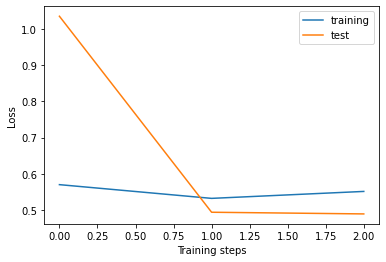

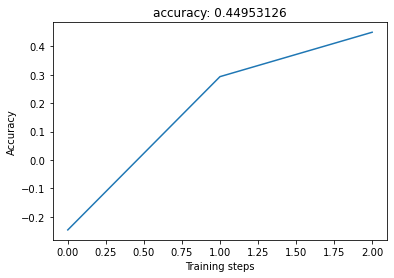

train_loss: 0.5514 test_loss: 0.5404 test_acc: 0.3986 running: 1644.4 sec ETA: 246.7 min
Epoch: __ 3
train_loss: 0.5076 test_loss: 0.4366 test_acc: 0.4393 running: 2152.0 sec ETA: 233.1 min
Epoch: __ 4
INFO:tensorflow:Assets written to: ./Model/modelX1\assets


INFO:tensorflow:Assets written to: ./Model/modelX1\assets


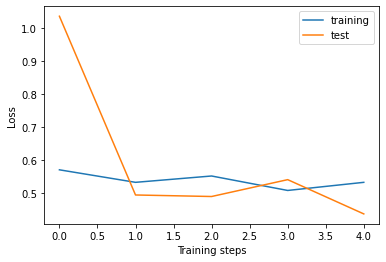

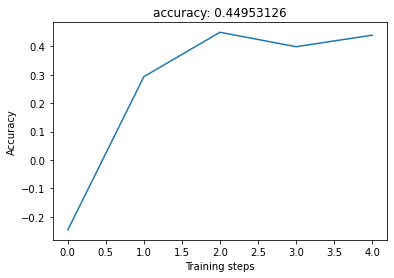

train_loss: 0.5322 test_loss: 0.3930 test_acc: 0.2924 running: 2684.0 sec ETA: 223.7 min
Epoch: __ 5
train_loss: 0.4749 test_loss: 0.4165 test_acc: 0.3622 running: 3192.6 sec ETA: 212.8 min
Epoch: __ 6
INFO:tensorflow:Assets written to: ./Model/modelX1\assets


INFO:tensorflow:Assets written to: ./Model/modelX1\assets


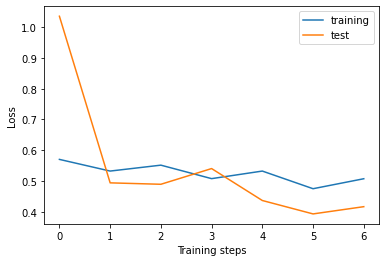

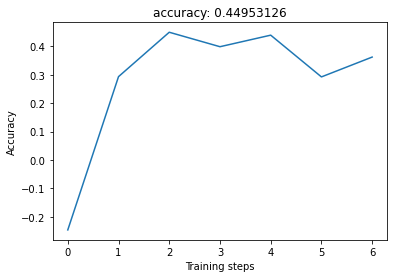

train_loss: 0.5073 test_loss: 0.3898 test_acc: 0.4317 running: 3993.9 sec ETA: 218.7 min
Epoch: __ 7


KeyboardInterrupt: 

In [13]:
tf.keras.backend.clear_session()


### Hyperparameters
num_epochs = 30
learning_rate = 0.001
running_average_factor = 0.95

# Initialize the model.
model = my_CNN(26,box_width)
helper_obj = helper()

# Using MeanSquaredError to sovle a regression task
loss_fuction = tf.keras.losses.MeanSquaredError()
acc_function = tf.keras.losses.MeanAbsolutePercentageError()

# Using the Adam optimizer with the defined learnig rate
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Initialize lists for later visualization.
train_losses = []
test_losses = []
test_accuracies = []

#testing once before we begin
test_loss, test_accuracy = helper_obj.test(model, test_ds, loss_fuction, acc_function)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)
print(model.summary())
print("Pre-learning")
print('test loss: {:.4f} acc: {:.4f}'.format(test_loss, test_accuracy))

# We train for num_epochs epochs.
time0 = time.time()
for epoch in range(num_epochs):
    print('Epoch: __ ' + str(epoch))
    train_ds = train_ds.shuffle(buffer_size=512)
    test_ds = test_ds.shuffle(buffer_size=512)

    #training (and checking in with training)
    running_average = 0
    for (input,target) in train_ds:
        train_loss = helper_obj.train_step(model, input, target, loss_fuction, optimizer)
        running_average = running_average_factor * running_average  + (1 - running_average_factor) * train_loss
    train_losses.append(running_average)
    if epoch > 0 and epoch%2 == 0:
        model.save(drive_str+"/Model/modelX1")
        plt.figure()
        line1, = plt.plot(train_losses)
        line2, = plt.plot(test_losses)
        plt.xlabel("Training steps")
        plt.ylabel("Loss")
        plt.legend((line1,line2),("training","test"))
        plt.show()
        plt.figure()
        line1, = plt.plot(test_accuracies)
        plt.title('accuracy: '+ str(np.max(test_accuracies)))
        plt.xlabel("Training steps")
        plt.ylabel("Accuracy")
        plt.show()

    #testing
    test_loss, test_accuracy = helper_obj.test(model, test_ds, loss_fuction, acc_function)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    run_time = time.time()-time0 
    print("train_loss: {:.4f} test_loss: {:.4f} test_acc: {:.4f} running: {:.1f} sec ETA: {:.1f} min".format(running_average.numpy(), test_loss, test_accuracy, run_time, (run_time/(epoch+1)*num_epochs-run_time)/60))

Needed 3.3s


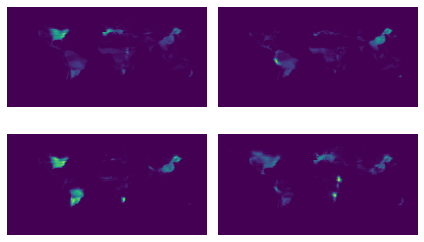

In [32]:
# prediction for the last year of the dataset 2016

model = tf.keras.models.load_model(drive_str+"/Model/modelX1")
prediction_map = np.zeros((181,360,4))
year = 2016
x_batch_list = []
lat_lon_list = []
time0 = time.time()
for lat in range(box_width, 181-box_width):
    for lon in range(box_width, 360-box_width):
        if data_obj.past_data[year][0][lat,lon,-1] == 1:
            x = data_obj.past_data[year][0][lat-box_width:lat+box_width+1,lon-box_width:lon+box_width+1,:]
            x_batch_list.append(x)
            lat_lon_list.append((lat,lon))
x_batch = np.stack(x_batch_list)
x_norm = (x_batch - data_obj.norm_params[0][0]) / data_obj.norm_params[0][1] 
y_batch = model(x_norm) 
y_norm = y_batch * data_obj.norm_params[1][1] + data_obj.norm_params[1][0]

for y, lat_lon in zip(y_norm, lat_lon_list):
    prediction_map[lat_lon[0],lat_lon[1],:] = y[0,:]

print("Needed {:.1f}s".format(time.time()-time0))

vmax = np.max(prediction_map)
fig, axes = plt.subplots(2,2)
for ax,i in zip(axes.flat,range(4)):
    im = ax.imshow(prediction_map[:,:,i], origin="lower", vmin=0)
    ax.axis('off')
plt.tight_layout()
plt.show()

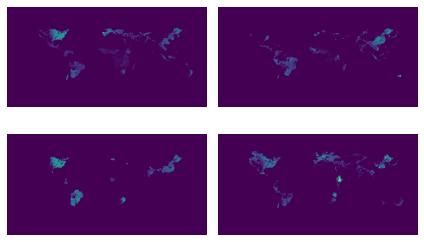

In [33]:
# actual distribution of the crop yields in the year 2016

fig, axes = plt.subplots(2,2)
for ax,i in zip(axes.flat,range(4)):
    im = ax.imshow(data_obj.past_data[2016][1][:,:,i], origin="lower", vmin=0)
    ax.axis("off")
plt.tight_layout()
plt.show()

reading scenario ssp126
reading scenario ssp370
reading scenario ssp585
[ 1.95596104e-05  1.38273629e-05  7.03670517e-06  1.47426721e-05
  8.72532022e-06  1.26906913e-05  1.76450826e-05  1.71917990e-05
  4.29543807e-06  1.01122291e-05  1.34728137e-05  1.48994346e-05
  2.69418094e+02  2.62468507e+02  2.51141696e+02  2.56581836e+02
  2.56605850e+02  2.60740735e+02  2.70259850e+02  2.63022629e+02
  2.48004695e+02  2.58698748e+02  2.58862196e+02  2.62210023e+02
 -7.40000000e+01  0.00000000e+00]


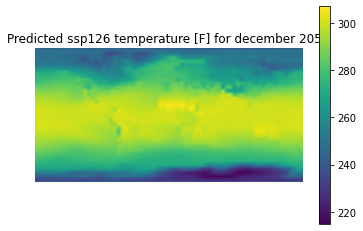

In [16]:
data_obj.read_future_data()

print(data_obj.fut_data[0][2050][15,40,:])
plt.imshow(data_obj.fut_data[0][2050][:,:,-3], origin="lower")
plt.axis("off")
plt.colorbar()
plt.title("Predicted ssp126 temperature [F] for december 2050")
plt.show()

In [17]:
# future prediction
model = tf.keras.models.load_model(drive_str+"/Model/modelX1")

fut_map = [np.zeros((80,36,72,4)), np.zeros((80,36,72,4)), np.zeros((80,36,72,4))]
time0 = time.time()
for scenario_number in range(3):
    for i in range(80):
        year = 2021 + i
        x_batch_list = []
        lat_lon_list = []

        np.zeros((36,72,4))
        for lat in np.arange(box_width,180-box_width,5):
            for lon in np.arange(box_width,360-box_width,5):
                if data_obj.fut_data[scenario_number][year][lat,lon,-1] == 1:
                    x = data_obj.fut_data[scenario_number][year][lat-box_width:lat+box_width+1,lon-box_width:lon+box_width+1,:]
                    x_batch_list.append(x)
                    lat_lon_list.append((int(lat/5),int(lon/5)))
        x_batch = np.stack(x_batch_list)
        x_norm = (x_batch - data_obj.norm_params[0][0]) / data_obj.norm_params[0][1] 
        y_batch = model(x_norm) 
        y_norm = y_batch * data_obj.norm_params[1][1] + data_obj.norm_params[1][0]

        for y, lat_lon in zip(y_norm, lat_lon_list):
            fut_map[scenario_number][i,lat_lon[0],lat_lon[1],:] = y[:]

print("Needed {:.1f}s".format(time.time()-time0))

Needed 44.6s


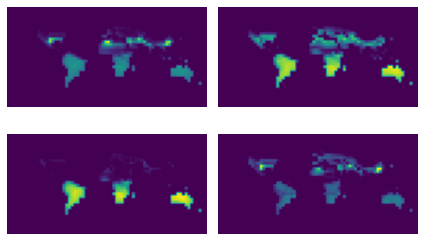

In [18]:
# predicted crop yield distribution for the year 2100 in the ssp585 scenario
fig, axes = plt.subplots(2,2)
for ax,i in zip(axes.flat,range(4)):
    im = ax.imshow(fut_map[2][79,:,:,i], origin="lower", vmin=0)
    ax.axis('off')
plt.tight_layout()
plt.show()

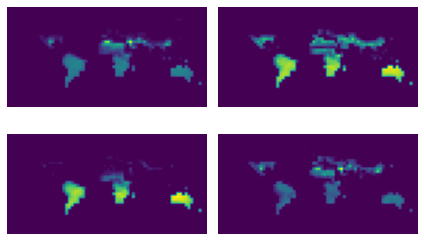

In [34]:
# predicted crop yield distribution for the year 2050 in the ssp585 scenario
fig, axes = plt.subplots(2,2)
for ax,i in zip(axes.flat,range(4)):
    im = ax.imshow(fut_map[2][29,:,:,i], origin="lower", vmin=0)
    ax.axis('off')
plt.tight_layout()
plt.show()

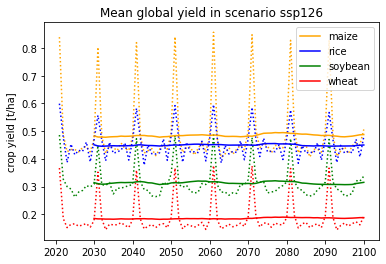

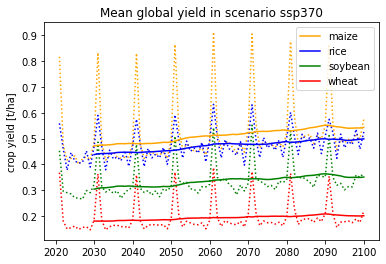

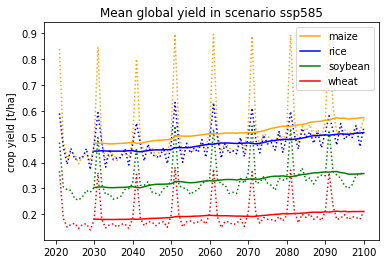

In [19]:
for map,scenario in zip(fut_map,["ssp126", "ssp370", "ssp585"]):
    df = pd.DataFrame(np.mean(np.mean(map.clip(min=0),axis=1),axis=1))
    df["maize"] = df[0].rolling(10).mean()
    df["rice"] = df[1].rolling(10).mean()
    df["soybean"] = df[2].rolling(10).mean()
    df["wheat"] = df[3].rolling(10).mean()
    x = range(2021,2101)
    plt.plot(x,df[0],color="orange",linestyle="dotted")
    plt.plot(x,df[1],color="blue",linestyle="dotted")
    plt.plot(x,df[2],color="green",linestyle="dotted")
    plt.plot(x,df[3],color="red",linestyle="dotted")
    plt.plot(x,df["maize"],color="orange",label="maize")
    plt.plot(x,df["rice"],color="blue",label="rice")
    plt.plot(x,df["soybean"],color="green",label="soybean")
    plt.plot(x,df["wheat"],color="red",label="wheat")
    plt.legend()
    plt.title("Mean global yield in scenario {}".format(scenario))
    plt.ylabel('crop yield [t/ha]')
    plt.show()

In [31]:
for year in range(80):
    #print(year+2021)
    fig, axes = plt.subplots(2,2)#, figsize=(20,30))
    #ax.set_title("Year {}".format(year))
    for ax,i in zip(axes.flat,range(4)):
        ax.imshow(fut_map[2][year,:,:,i], origin="lower", vmin=0)#, vmax=vmax)
        ax.axis('off')
    title = axes[0,0].text(1.15,1.2,"Scenario ssp585 Year {}".format(2021+year), 
                    size=plt.rcParams["axes.titlesize"],
                    ha="center", transform=axes[0,0].transAxes, )
    plt.savefig("{}/video_png/frame_{}.png".format(drive_str, year+2021), dpi=200)
    #plt.show()
    plt.close(fig)
    #break
    
img_array = []
for year in range(80):
    img = cv2.imread("{}/video_png/frame_{}.png".format(drive_str, year+2021))
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)
 
 
out = cv2.VideoWriter(drive_str+ '/movie1.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 4, size)
 
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()

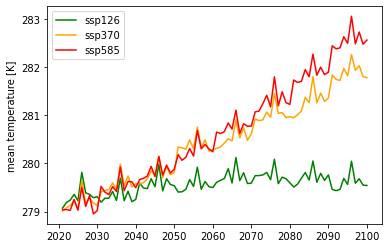

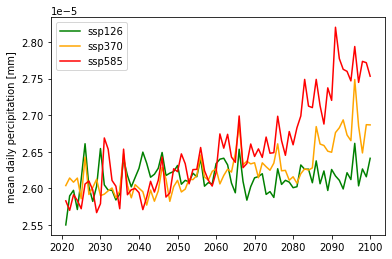

In [58]:
cmip = [np.zeros((80,2)), np.zeros((80,2)), np.zeros((80,2))]
for year in range(80):
    for scenario in range(3):
        cmip[scenario][year,0]= np.mean(data_obj.fut_data[scenario][year + 2021][:, :, :12])
        cmip[scenario][year,1]= np.mean(data_obj.fut_data[scenario][year + 2021][:, :, 12:24])
        x = range(2021,2101)
plt.plot(x,cmip[0][:,1], color="green", label="ssp126")
plt.plot(x,cmip[1][:,1], color="orange", label="ssp370")
plt.plot(x,cmip[2][:,1], color="red", label="ssp585")
plt.legend()
plt.ylabel("mean temperature [K]")
plt.show()
plt.plot(x,cmip[0][:,0], color="green", label="ssp126")
plt.plot(x,cmip[1][:,0], color="orange", label="ssp370")
plt.plot(x,cmip[2][:,0], color="red", label="ssp585")
plt.legend()
plt.ylabel("mean daily percipitation [mm]")
plt.show()